In [1]:
from pathos.multiprocessing import ProcessPool
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

In [2]:
# instantiate and configure the worker pool
pool = ProcessPool(nodes=4)
# do a blocking map on the chosen function
#results = pool.map(pow, [1,2,3,4], [5,6,7,8])
# do a non-blocking map, then extract the results from the iterator
#results = pool.imap(pow, [1,2,3,4], [5,6,7,8])
#results = list(results)
# do an asynchronous map, then get the results
results = pool.amap(pow, [1,2,3,4], [5,6,7,8])
results = results.get()
#print(results)
r_test = np.random.uniform(-1/2, 1/2, (4, 3))

#print(pool.map(f, r_test, r_test))

In [3]:
N_0 = 2
h = 0.032
m = 48
T = 1
L = 1
sigma = 3.405 #Armstrong
epsilon = 119.8 #K


r_0 = np.random.uniform(-L/2, L/2, (N_0, 3)) #randomly between 0 and L with gaussian distribution, mean 0, std sqrt(kT^*/m^*), m^* = 48, k = 1, are the velocities normally distributed in every seperate direction?
v_0 = np.random.normal(0,np.sqrt(T/48), (N_0, 3))

"""
r_0: Initial positions of the system
    r_0[i]: 1D-array with 3 values, the coordinates of the i'th particle
v_0: Initial velocities of the system particles
    v_0[i]: 1D-array with 3 values, the velocity values of the i'th particle
"""

list_pbc = [[0,0,0],[L,0,0],[0,L,0],[0,0,L],[-L,0,0],[0,-L,0],[0,0,-L]]
list_pbc = np.array(list_pbc)

def f(r_i, r_j):
    r_ij = np.sqrt(np.sum([np.min([(r_i[d]-r_j[d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)]))
    f_x = m*(r_i[0]-r_j[0])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_y = m*(r_i[1]-r_j[1])*(r_ij**(-14)+0.5*r_ij**(-8))
    f_z = m*(r_i[2]-r_j[2])*(r_ij**(-14)+0.5*r_ij**(-8))
    return np.array([f_x, f_y, f_z])

def arange_without(i):
    original_array = np.arange(N_0)
    result_array = original_array[original_array != i]
    return result_array

def F(r):
    return np.array([np.sum(np.array([f(r[i], r[k]) for k in arange_without(i)]), axis=0) for i in range(r.shape[0])])
    #return [f(r[i], r[k]) for k in arange_without(i)] pool.map()

    #pool = ProcessPool(nodes=4)
    #results = pool.map(f_subprocess, (r for i in range(r.shape[0])), range(r.shape[0]))
    #return np.array(results)

def f_sum(r, i):
    #[f(r[i], r[k]) for k in arange_without(i)]
    aw = arange_without(i)
    pool.map(f, r[i], r[aw])

def f_subprocess(r, i):
    import numpy as np

    N_0 = 800
    h = 0.032
    m = 48
    T = 1
    L = 1

    list_pbc = [[0,0,0],[L,0,0],[0,L,0],[0,0,L],[-L,0,0],[0,-L,0],[0,0,-L]]
    list_pbc = np.array(list_pbc)
    
    def arange_without(i):
        original_array = np.arange(N_0)
        result_array = original_array[original_array != i]
        return result_array

    def f(r_i, r_j):
        r_ij = np.sqrt(np.sum([np.min([(r_i[d]-r_j[d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)]))
        f_x = m*(r_i[0]-r_j[0])*(r_ij**(-14)+0.5*r_ij**(-8))
        f_y = m*(r_i[1]-r_j[1])*(r_ij**(-14)+0.5*r_ij**(-8))
        f_z = m*(r_i[2]-r_j[2])*(r_ij**(-14)+0.5*r_ij**(-8))
        return np.array([f_x, f_y, f_z])
    return np.sum(np.array([f(r[i], r[k]) for k in arange_without(i)]), axis=0)

def verlet_step(r, v):
    v_tilde = v + h/(2*m)*F(r)
    r_next = r + h*v_tilde
    f_next = F(r_next)
    v_next = v_tilde + (h/(2*m))*f_next
    return r_next, v_next

def verlet_algorithm(r_0, v_0, num_steps):
    list_r = [r_0]
    list_v = [v_0]
    for t in tqdm(range(num_steps)):
        r_new, v_new = verlet_step(list_r[-1], list_v[-1])
        list_r.append(r_new)
        list_v.append(v_new)
    return np.array(list_r), np.array(list_v)

def Temperature(v):
    return 16*np.mean([(v_i[0]**2)+(v_i[1]**2)+(v_i[2]**2) for v_i in v])

Text(0.5, 0.92, 'Initial state of the Argon ')

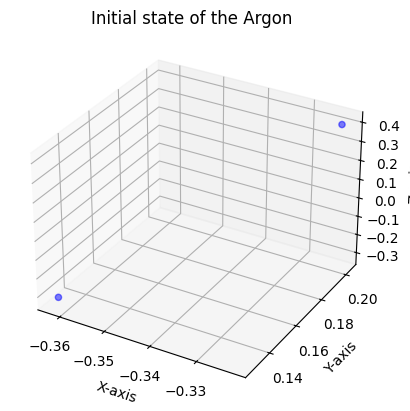

In [4]:
#Seeing how the initial state looks like
#ax = plt.figure().add_subplot(projection='3d')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Extract x, y, and z coordinates
x = r_0[:,0].flatten()
y = r_0[:,1].flatten()
z = r_0[:,2].flatten()

# Plot the points
ax.scatter(x, y, z, c='b', marker='o', alpha=0.5)

# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

In [5]:
t_max = 10
r_total, v_total = verlet_algorithm(r_0, v_0, t_max)
T_total = [Temperature(v_t) for v_t in v_total]

100%|██████████| 10/10 [00:00<00:00, 4999.77it/s]


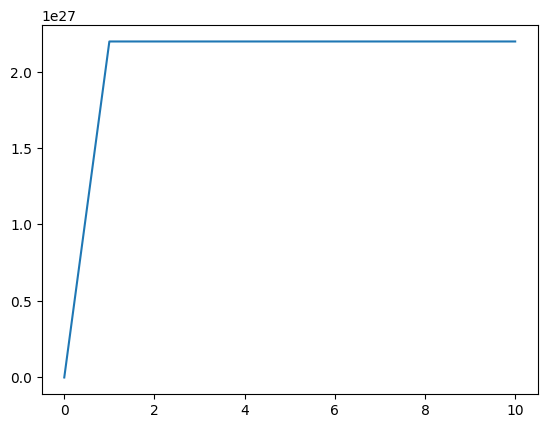

In [6]:
plt.plot(np.arange(t_max+1), T_total)

(10, 3, 2)


Text(0.5, 0.92, 'Initial state of the Argon ')

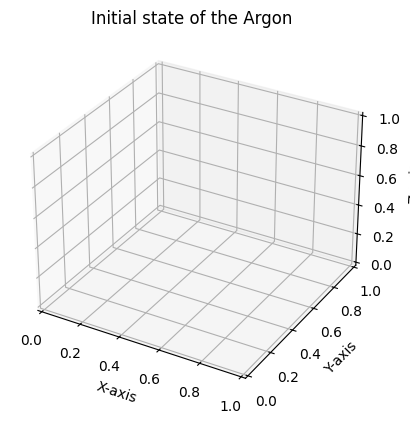

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

points = {0: [], 1: []}
# Extract x, y, and z coordinates
for t in range(t_max):
    for i in range(2):
        x = r_total[t,:,0].flatten()
        y = r_total[t,:,1].flatten()
        z = r_total[t,:,2].flatten()
        p = (x,y,z)
        points[i].append(p)
    
    # Plot the points
#ax.plot(points[0][0], points[0][1], points[0][2], marker='o', alpha=0.5, label = "particle 0")
print(np.array(points[0]).shape)
# Set labels
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

# Set the title
ax.set_title('Initial state of the Argon ')

# Show the plot
#plt.show()

#N_0 = 2, tmax = 10, dim = 3

In [8]:
#print(r_0[2])
#print(r_0[3])
#print("R_ij", np.sqrt(np.sum([np.min([(r_0[2][d]-r_0[3][d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)])))
#print(m*(r_0[2][0]-r_0[3][0])*(np.sqrt(np.sum([np.min([(r_0[2][d]-r_0[3][d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)])))**(-14)+0.5*np.sqrt(np.sum([np.min([(r_0[2][d]-r_0[3][d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)]))**(-8))
#print((np.sqrt(np.sum([np.min([(r_0[2][d]-r_0[3][d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)])))**(-14))
#print(f(r_0[2], r_0[3]))

IndexError: index 2 is out of bounds for axis 0 with size 2

In [ ]:
#print(np.sum([np.sqrt(np.sum([np.min([(r_0[n][d]-r_0[n+1][d]+vec_L[d])**2 for vec_L in list_pbc]) for d in range(2)]))- np.sqrt(np.sum([(r_0[n][d]-r_0[n+1][d])**2 for d in range(2)])) for n in range(N_0-1)]))

(3, 5)


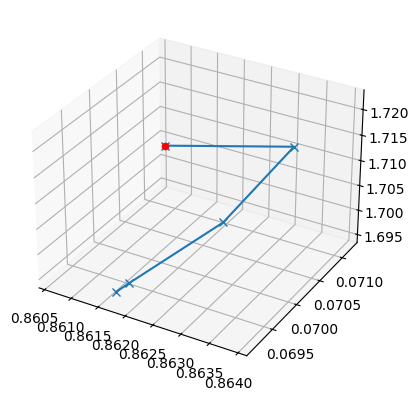

In [25]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

points = np.array([[ 0.86063431,  0.07119279,  1.70377142],
                       [ 0.86391084,  0.07014899,  1.72184785],
                       [ 0.86332177,  0.069444  ,  1.71182579],
                       [ 0.86192988,  0.06913941,  1.69818289],
                       [ 0.86166436,  0.06916367,  1.69527615]]).T
    
print(points.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot(points[0], points[1], points[2], marker = 'x')
ax.scatter(*points.T[0], color = 'red')
plt.show()